# CS 444: Deep Learning for Computer Vision, Fall 2023, Assignment 5

Assignment is due at 11:59:59 PM on Thursday Nov 30 2023.

1. Assignment is due at **11:59:59 PM on Thursday Nov 30 2023**.

2. See [policies](https://saurabhg.web.illinois.edu/teaching/cs444/fa2023/policies.html) on [class website](https://saurabhg.web.illinois.edu/teaching/cs444/fa2023).

3. Submission instructions:
    1. On gradescope assignment called `MP5-code`, upload the following  files:
        - Your completed `vae.py` and `score.py`.

       Please also note the following points:
        - Do not compress the files into `.zip` as this will not work.
        - Do not change the provided files names nor the names of the functions but rather change the code inside the provided functions and add new functions. Also, make sure that the inputs and outputs of the provided functions are not changed.
        - The autograder will give you feedback on how well your code did.
        - The autograder is configured with the python libraries: `numpy matplotlib tqdm torch` only.

4. Lastly, be careful not to work of a public fork of this repo. Make a private clone to work on your assignment. You are responsible for preventing other students from copying your work.

In this notebook, we will implement the several generative models and compare their performance on the swiss roll dataset and MNIST dataset. Specifically, we will focus on score matching and implement the [Noise-Conditioned Score Network](https://arxiv.org/abs/1907.05600) (NSCN):

## Prerequisites

In this MP, you will implement the network architectures defined in `vae.py` and `score.py`. You can use this Jupyter Notebook for testing your implementation and visualizing your results. To facilitate your testing, enable the autoreload extension so that your modifications to the `.py` files will be automatically reloaded:


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import unittest
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from vae import VAE
from score import ScoreNet

## Part 1. Swiss Roll

In the first part, you are expected to implement the VAE and score-matching model on the Swiss roll dataset.

In [3]:
def make_swiss_roll(n_samples=100, *, noise=0.0, seed=None):
    generator = torch.Generator()
    generator.manual_seed(seed)
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples, generator=generator))
    x = t * torch.cos(t)
    y = t * torch.sin(t)

    X = torch.stack((x, y), dim=1)
    X += noise * torch.randn(n_samples, 2, generator=generator)
    return X, t

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

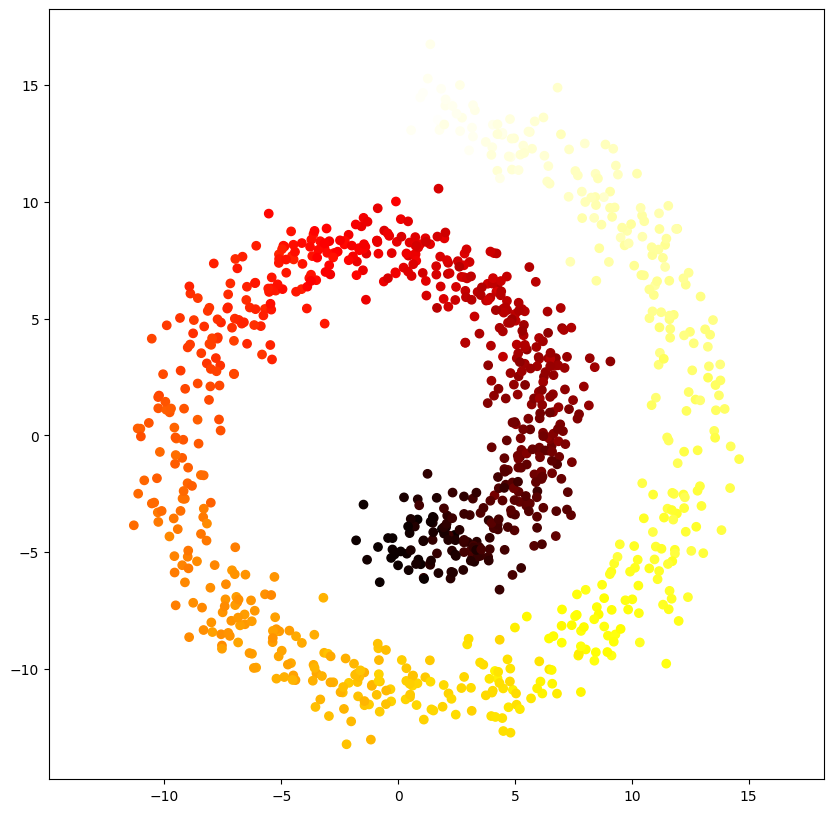

In [4]:
X, t = make_swiss_roll(n_samples=1000, noise=1., seed=42)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis('equal')
plt.show()

### Simple Encoder and Decoder

In [5]:
class SimpleEncoder(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, latent_size=64):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
        )

    def forward(self, x):
        return self.encoder(x)


class SimpleDecoder(nn.Module):
    def __init__(self, latent_size=32, hidden_size=128, output_size=2):
        super().__init__()
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.decoder(x)

## VAE

**Q1.1 [1 pts Autograded]** Implement the `reparameterize` method in `vae.py`. This method takes in the mean and log-variance of the latent distribution and returns a sample from the distribution.

Once you have implemented the method, run the following cell to test your implementation.

In [6]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_vae_reparam')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.226s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Q1.2 [3 pts Autograded]** Implement the `get_loss` method in `vae.py`. This method takes in a batch of data and returns the VAE loss. You should compute the reconstruction loss and the KL divergence loss and return the sum of the two losses. The reconstruction loss is the **mean squared error** between the reconstructed images and the original images. The KL divergence loss can be computed in closed form, and you should **sum** it along latent dimensions.

**Hint**. The KL-divergence between a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and a standard Gaussian distribution $\mathcal{N}(0,1)$ is given by:

$$
\mathcal{D}_{\text{KL}}(\mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1)) = \frac{1}{2}\left( \sigma^2 + \mu^2 - 1 - \log \sigma^2 \right)
$$

Once you have implemented the method, run the following cell to test your implementation.

In [7]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_vae_loss')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.065s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Now train your VAE model on the Swiss roll dataset and try to generate some points after training.

In [8]:
vae = VAE(
    SimpleEncoder(input_size=2, hidden_size=128, latent_size=10 * 2),
    SimpleDecoder(latent_size=10, hidden_size=128, output_size=2)
)
print(f'Number of parameters in VAE: {count_parameters(vae)}')
vae.train()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = vae.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Number of parameters in VAE: 37654
Epoch 0, loss 51.7266
Epoch 200, loss 6.1238
Epoch 400, loss 4.7980
Epoch 600, loss 4.7105
Epoch 800, loss 4.8008
Epoch 1000, loss 4.7082
Epoch 1200, loss 4.6861
Epoch 1400, loss 4.7084
Epoch 1600, loss 4.6588
Epoch 1800, loss 4.6814
Done!


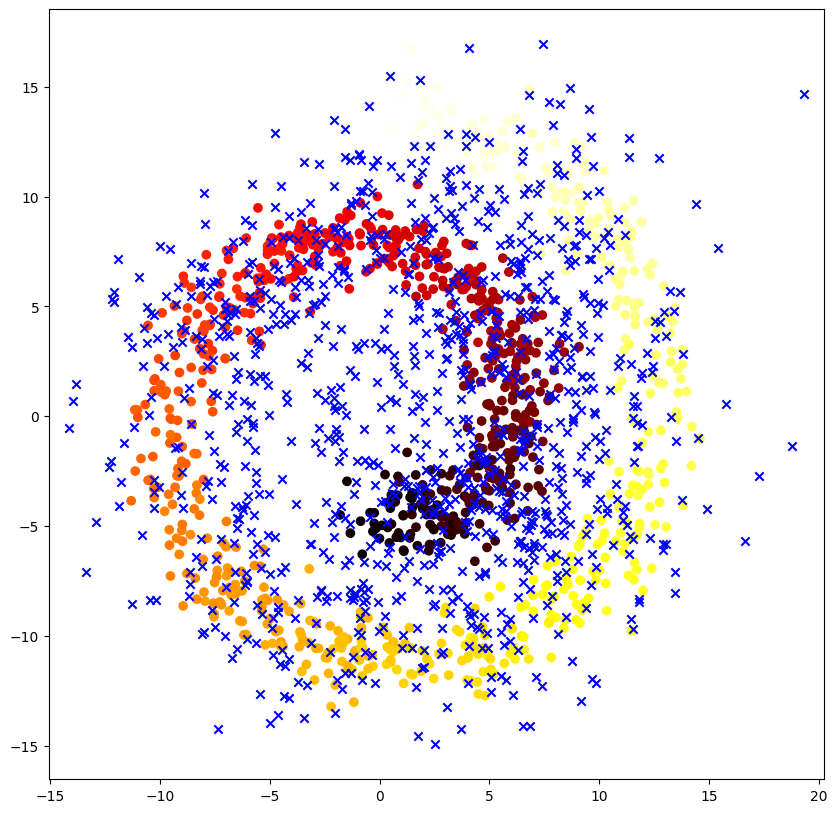

In [9]:
n_sample = 1000
vae.eval()
with torch.no_grad():
    X_gen = vae.sample(n_sample, 'cpu')
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

## Part 2: Score Matching

In this part, you are expected to implement the score matching model on the Swiss roll dataset.

**Q2.1 [2 pts Autograded]** Implement the `perturb` method in `score.py`. This function takes in a batch of data and returns a perturbed batch of data. Specifically, you should first choose uniformly random from `self.simgas` for each data (NOT each pixel/coordinate!). Then add the Gaussian noise the data with standard deviation `sigma`. Return the applied noise and used sigma values. DO NOT clip the perturbed data!

Once you have implemented the method, run the following cell to test your implementation.

In [10]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_perturb')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.316s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Q2.2 [3 pts Autograded]** Implement the `get_loss` method in `score.py`. You should first call `perturb` to obtain the noise and perturbed data and call `get_score` to obtain the estimated scores for the perturbed data. The score loss in NCSNv2 is defined as:

$$
\mathcal{L}_{\text{score}} = \frac{1}{2}\mathbb{E}_{\sigma} \mathbb{E}_{\hat{\mathbf{x}}\sim p(\mathbf{\hat{x}},\mathbf{x})} \left[ \left( s(\hat{\mathbf{x}}) - \frac{\mathbf{x} - \mathbf{\hat{x}}}{\sigma^2} \right)^2\cdot \sigma^2 \right]
$$

where $\mathbf{x}$ is the original data and $\mathbf{\hat{x}}$ is the perturbed data. $\sigma$ is the standard deviation of the noise, and $s(\hat{\mathbf{x}})$ is the estimated score for the perturbed data. The loss should be **averaged** over the batch dimension and the image dimensions.

Once you have implemented the method, run the following cell to test your implementation.

In [11]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_loss')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.160s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Q2.3 [2 pts Autograded]** Complete the `sample` method in `score.py`. Recall that in Langevin dynamics, the update rule is:

$$
\mathbf{x}_{t+1} = \mathbf{x}_t + \eta\nabla_{\mathbf{x}}\log p(\mathbf{x}) + \sqrt{2\eta}\mathbf{z}_t
$$

where $\mathbf{z}_t\sim \mathcal{N}(0, \mathbf{I})$. In this method, we first sample a batch of noise $\mathbf{z}_t$ and estimate the scores (gradient of the log density $\nabla_{\mathbf{x}}\log p(\mathbf{x})$) using `get_score`. Then you should compute the update $\mathbf{x}_{t+1}$ and return the sequence of updates.

Once you have implemented the method, run the following cell to test your implementation.


In [12]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_sample')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.067s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [13]:
scorenet = ScoreNet(
    torch.nn.Sequential(
        SimpleEncoder(input_size=2, hidden_size=128, latent_size=16),
        SimpleDecoder(latent_size=16, hidden_size=128, output_size=2),
    ), 10., 0.1, 20, 'geometric'
)
scorenet.train()
optimizer = optim.Adam(scorenet.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = scorenet.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Epoch 0, loss 0.5120
Epoch 200, loss 0.4298
Epoch 400, loss 0.4428
Epoch 600, loss 0.4385
Epoch 800, loss 0.4195
Epoch 1000, loss 0.4353
Epoch 1200, loss 0.4149
Epoch 1400, loss 0.3894
Epoch 1600, loss 0.4201
Epoch 1800, loss 0.4451
Done!


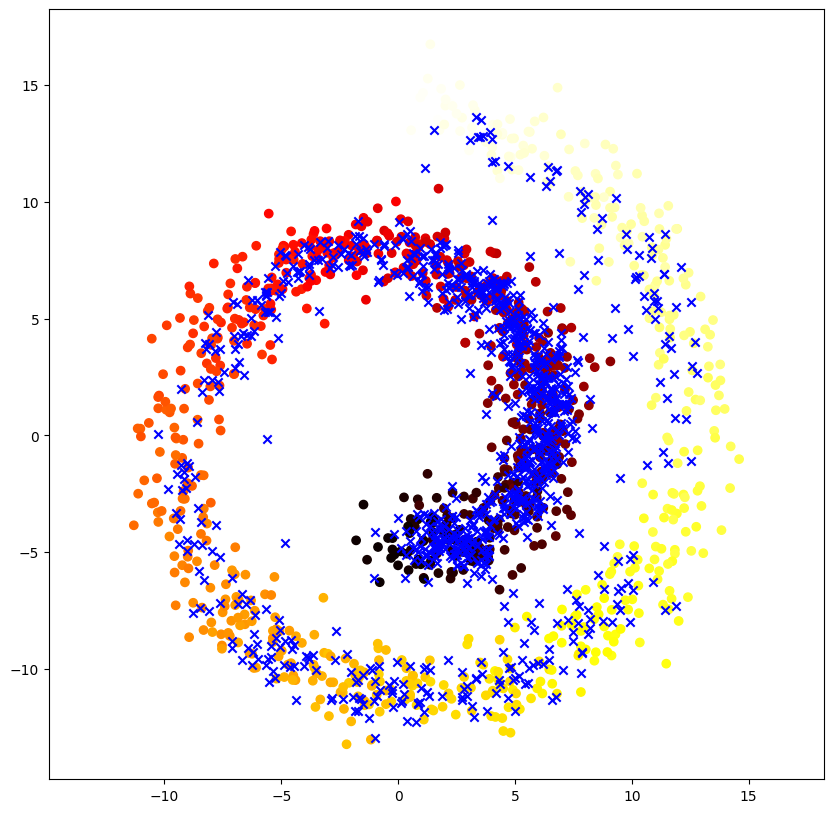

In [38]:
n_sample = 1000
scorenet.eval()
with torch.no_grad():
    X_gen = scorenet.sample(n_sample, 2, step_lr=1e-2)[-1, -1]
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

**Q2.4 [1 pts Manual graded]** Compare the sampled points from VAE and score matching and upload the visualization. Which model do you think performs the best?

**Q2.5 [1 pts Manual graded]** Modify the `step_lr` argument in the score-matching sampling and rerun the sampling for at least three different step sizes. Upload the visualization and discuss the effect of the step size on the sampling.